# Amharic Data Aggregation and Cleaning

This notebook gathers, compiles and cleans up the Amharic data collected from different sources and creates the three different versions of the Amharic benchmark dataset this project curates and uses (i.e., Amharic-1, Amharic-2, Amharic-3). It also presents descriptive statistics as well as visualizations of the token counts of the entries of these datasets.

The raw data files are all collected into the same folder and uploaded to Google Drive for this Colab notebook to access them. They come in .csv and .jsonl formats, and the sources of these data files are cited on the final report of this project.

In [ ]:
# Installing required packages
!pip install transformers sentencepiece > /dev/null 2>&1

In [ ]:
# Importing packages
import pandas as pd
import re
import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import MT5Tokenizer
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
# Mouting Google Drive to the current Colab session for accessing files stored in the Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the Google Drive folder where all the data files are
# This would be updated to a new path if the files are moved to a different location
folder_path = '/content/drive/My Drive/CPSC_490_Data/'

# Initializing an empty DataFrame to compile all data entries
aggregated_data = pd.DataFrame(columns=["text", "summary"])

In [ ]:
# Source: Israel Abebe Azime and Nebil Mohammed. An Amharic News Text classification Dataset, 2021.
# Link: https://arxiv.org/abs/2103.05639

# Aggregating from test.csv and train.csv files
for file_name in ["test.csv", "train.csv"]:
  df = pd.read_csv(folder_path + file_name)
  df = df[["article", "headline"]].rename(columns={"article":"text", "headline":"summary"}) # Renaming columns: article --> text, headline --> summary (to have consistent column names)

  print(df.head())
  aggregated_data = pd.concat([aggregated_data, df], ignore_index=True) # Adding to the aggregation dataframe

                                                text  \
0  ባለአምስት ኮከብ ሆቴል ስፔሻላይዝድ ሆስፒታልና የተለያዩ ግዙፍ አገልግሎት...   
1  የግል ባንኮች የተቀማጭ ገንዘብ በአንድ አመት ውስጥ በ276 በመቶ በመጨመ...   
2  በተጠርጣሪዎቹ ላይ የ14 ቀናት ምርመራ ጊዜ ተፈቅዷል ጠቅላይ ሚኒስትር አ...   
3  ከ2006 አም ጀምሮ የፌዴራል ከፍተኛ ፍርድ ቤት በዳኝነት ሲያገለግሉ የቆ...   
4  የአገሪቱን የኤታማዦር ሹም ጨምሮ አምስት ከፍተኛ የፌዴራል እና የክልል መ...   

                                             summary  
0  የአገልግሎት መስጫ ተቋማት ለመገንባት መሬት የጠየቁ በልዩ ሊዝ ተስተናገዱ...  
1                 የግል ባንኮች ተቀማጭ ገንዘብ 124 ቢሊዮን ብር ደረሰ  
2  በቦምብ ፍንዳታው ምክንያት ኃላፊነታቸውን አልተወጡም የተባሉ ተጠርጣሪዎች ...  
3          ለሕገ መንግሥቱ ታማኝ አይደሉም የተባሉት ዳኛ ከኃላፊነታቸው ተነሱ  
4                      የመሰንበቻው የባለሥልጣናቱ ግድያ እና አንድምታ  
                                                text  \
0  The Ethiopian national side continued on their...   
1  የይርጋለም የተቀናጀ የግብርና ኢንዱስትሪ ፓርክ 11 ሼዶች የተጠናቀቁ ሲሆ...   
2  በኮሮና ቀውስ ወቅት ትምህርት ቤቶች መዋእለ ህፃናት እና ሌሎች የልጆች መ...   
3  ባህር ዳር ግንቦት 242012 አም አብመድ ሯንዳ የእንቅስቃሴ ገደቦችን ለ...   
4  የምክር ቤቱ ምክትል አፈ ጉባኤ አቶ ወልደ ገብርኤል አብርሀ ዛሬ በአዲስ ... 

In [ ]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 51,483

Current Number of Entries:  51483


In [ ]:
# Source: Amr M. Zaki, Mahmoud I. Khalil, and Hazem M. Abbas. Amharic Abstractive Text Summarization, 2020.
# Link: https://arxiv.org/abs/2003.13721

# Aggregating from the CSV files starting with "news_" (there are many of them with such naming)
num_of_files = 0

for file_name in glob.glob(folder_path + "news_*.csv"):
  df = pd.read_csv(file_name)
  df = df[["content", "title"]].rename(columns={"content":"text", "title":"summary"}) # Renaming columns: content --> text, title --> summary (for consistency)
  num_of_files += 1 # Counting the number of files

  aggregated_data = pd.concat([aggregated_data, df], ignore_index=True) # Adding to the aggregation dataframe

print("Number of Files: ", num_of_files) # 7 files

Number of Files:  7


In [ ]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 126,259

Current Number of Entries:  126259


In [ ]:
# Source: Tahmid Hasan, Abhik Bhattacharjee, Md. Saiful Islam, Kazi Mubasshir, Yuan-Fang Li, Yong-Bin Kang, M. Sohel Rahman, and Rifat Shahriyar.
#         XL-Sum: Large-Scale Multilingual Abstractive Summarization for 44 Languages. In Chengqing Zong, Fei Xia, Wenjie Li, and Roberto Navigli, editors,
#         Findings of the Association for Computational Linguistics: ACL-IJCNLP 2021, pages 4693–4703, Online, August 2021. Association for Computational Linguistics.
# Link: https://aclanthology.org/2021.findings-acl.413

# Aggregating from 3 JSONL Files
for file_name in ["amharic_test.jsonl", "amharic_train.jsonl", "amharic_val.jsonl"]:
  df = pd.read_json(folder_path + file_name, lines=True) # Reading JSONL as dataframe
  df = df[["text", "summary"]] # Setting the column names to "text" and "summary" for consistency

  print(df.head())
  aggregated_data = pd.concat([aggregated_data, df], ignore_index = True) # Adding to the aggregation dataframe

                                                text  \
0  የ28 አመቷ ሴት ስሟ እንዲገለጥ ያልተፈለገ ሲሆን ንቦቹ አይኗ ውሰጥ ሲገ...   
1  ፎቶ፡ GettyImages የአረና ፓርቲ ሊቀመንብር አቶ አብርሃ ደስታ በላ...   
2  ይህ በሚሊዮኖች ዘንድ ተወዳጅነት ያተረፈ ማሕበራዊ ድር-አምባ እንዴት የአ...   
3  ሚኒስትሩን ዶ/ር ስለሺ በቀለን ዋቢ አድርገው የአገር ውስጥ ሚዲያዎች እን...   
4  በ140 ሃገራት ውስጥ የሚኖሩ 150 ሺህ የሚሆኑ ሰዎች ቃለመጠይቅ የተደረ...   

                                             summary  
0  በታይዋን ከአንዲት ሴት አይን ውስጥ ዶክተሮች አራት ንቦችን አወጡ። በደሴ...  
1  ከሰሞኑ ባለቤትነታቸው የአረና ትግራይ ፓርቲ አባል ናቸው የተባሉ አስራ ስ...  
2  የአሜሪካው ፕሬዝደንት ዶናልድ ትራምፕ ቲክ ቶክ የተሰኘው የተንቀሳቃሽ ምስ...  
3  የታላቁ ሕዳሴ ግድብ የመጀመሪያ ምዕራፍ ውሃ ሙሌት መጀመሩን የውሃ፣ መስኖ...  
4  የሰው ልጆች ተናዳጅ፣ ድብርታም እና ጭንቀታም እየሆኑ መምጣታቸውን በዓለም...  
                                                text  \
0  ሃያ መርሴዲስ ቤንዝ ቅንጡ መኪኖች፣ በባንክ የተደበቀ 3 ሚሊዮን ዶላር፣ ...   
1  (ከግራ ወደ ቀኝ) ፕሮፌሰር መረራ ጉዲና፣ አቶ አሉላ ሃይሉ፣ አቶ አዳነ ...   
2  የብር የመግዛት አቅም እየቀነሰ ነው "ሃገር ውስጥ የሚመረቱ እንደ ሽንኩር...   
3  ሰሞኑን ኢትዮ-ቴሌኮም ተንቀሳቃሽ ስልኮችን ለመመዝገብ የወጣው ጥሪ ተንቀሳ...   
4  ኒማ በተባለው ፖሊስ ጣቢያ መስኮት ሰብረው በመግባት መዝረፋቸው ተገልጿል።... 

In [ ]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 133,458

Current Number of Entries:  133458


In [ ]:
# Source: Amr M. Zaki, Mahmoud I. Khalil, and Hazem M. Abbas. Amharic Abstractive Text Summarization, 2020.
# Link: https://arxiv.org/abs/2003.13721

# Aggregating 2 more CSV files from this source
csv_mappings = {
    "amhari_sent_min15.csv": ["Text", "Summary"],
    "Amhari_clean_tokenized.csv": ["Text", "Summary"]
}

for file_name, columns in csv_mappings.items():
  df = pd.read_csv(folder_path + file_name)
  df = df[columns].rename(columns={columns[0] : "text", columns[1]: "summary"}) # Renaming column names: Text --> text, Summary --> summary (for consistency)

  print(df.head())
  aggregated_data = pd.concat([aggregated_data, df], ignore_index = True)  # Adding to the aggregation dataframe


                                                text  \
0  በስመ አብ ፤  ወወልድ ፤  ወመንፈስ ቅዱስ ፤  አሐዱ አምላክ አሜን ። ...   
1  ሚያዝያ  ቀን  ዓም የአንድነት ፓርቲ ብምቤት ባደረገው ስብሰባ ላይ ባስተ...   
2  የኢትዮጵያንና የሱዳንን ድንበር የማካለሉ ሥራ ከመስከረም  ቀን  ዓም Oc...   
3  በአርዕስቱ ለመጥቀስ እንደሞከርኩኝ የኦሮሞ ህዝብ ትግል ከትውልድ ለትውልድ...   
4  ይሻል መጣ ብዬ ምርኩዝ አስጨበጨ መንገድ ያሳየሁት ፣  , ለካ ሌላም አይ...   

                                             summary  
0  ለርዕሰ አድባራት ለንደን ደብረ ጽዮን ቅድስት ማርያም የኢትዮጵያ ኦርቶዶክ...  
1  የአንድነት  መድረክ የፖለቲካ ግንኙነት እና የጋራ እንቅስቃሴ ከመቀናጀት ...  
2  ጀግኖች አባቶቻችን ደም የተቦካው ሉአላዊ ግዛታችን ላይ የሚደረገውን ስውር...  
3  የኦሮሞ ህዝብ ትግል ከጭቁን የአማራ ህዝብ ጋር ሳይሆን ከገዢው መደብና ከ...  
4  ይሻል መጣ ብዬ ምርኩዝ አስጨበጨ መንገድ ያሳየሁት ፣  ለካ ሌላም አይደል...  
                                                text                summary
0  አረንጓዴ ፡ ብጫና ፡ ቀይ ፡ ሰንደቅ ፡ ዓላማችን ፡  የአንድ ፡ ኢትዮጵ...          ሰንደቅ ፡ ዓላማችንን
1  ለኢትዮጵያ የጥምር መንግስት ያስፈልጋታል በማለት በ ምርጫ አጥብቆ ሲከራከ...  ለዚህ መንግሥት ታላቅ ክብር አለኝ
2  ቀጭኑ ዘቄራ  , ለአዲስ አበባ ከተማ ክብር ያላችሁ እንስማማለን ።  አዲ...         ግራውንድ ሲቀነስ አንድ
3  ህወሓት የአጋር ፓርቲዎቹን የንግድ ተቋማት

In [ ]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 206,902

Current Number of Entries:  206902


## Data Cleaning

The following chunks perform specific data cleaning steps to improve the quality of the aggregated dataset. These include the removal of duplicates and NaN/incomplete entries as well as predominantly non-Amharic entries.

In [ ]:
# Remove duplicates based on 'text' and 'summary' columns
aggregated_data.drop_duplicates(subset=['text', 'summary'], inplace=True)

duplicate_count = aggregated_data.duplicated(subset=['text', 'summary']).sum()
print(f"Number of duplicate rows: {duplicate_count}") # There doesn't seem to be any duplicates

Number of duplicate rows: 0


In [ ]:
# Removing any NaN (incomplete) entries
aggregated_data = aggregated_data.dropna(subset=['text', 'summary'])

In [ ]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 168,533

Current Number of Entries:  168533


In [ ]:
# Checking for any gibberish, non-Amharic or unexpected characters

# Pattern for Geez (Amharic) characters, numbers, spaces, and specific punctuations
geez_pattern = re.compile(r'[\u1200-\u137F0-9\s‹›፡።፣፤፦]')

def has_non_amharic(text):
  '''
  Determine if the given text contains significant non-Amharic characters (50% or more).

  Args:
    text (str): The text to be analyzed.

  Returns:
    bool: True if non-Amharic content is significant, False otherwise.
  '''
  # Checking if the text is a string
  if not isinstance(text, str):
      return False

  # Finding the regex pattern for Amharic
  amharic_chars = geez_pattern.findall(text)

  # 80% threshold to say Amharic or non-Amharic (i.e., at least 80% of the characters have to be Amharic)
  # This percentage was set to 50% during the preparation of Amharic-1
  if len(amharic_chars) / len(text) < 0.8:
    return True

  return False

# Applying non-Amharic check
aggregated_data['is_non_amharic_text'] = aggregated_data['text'].apply(has_non_amharic) # On the text column
aggregated_data['is_non_amharic_summary'] = aggregated_data['summary'].apply(has_non_amharic) # On the summary column

# Filtering out non-Amharic rows
aggregated_data_filtered = aggregated_data[~(aggregated_data['is_non_amharic_text'] | aggregated_data['is_non_amharic_summary'])]

print(aggregated_data_filtered.head())

                                                text  \
0  ባለአምስት ኮከብ ሆቴል ስፔሻላይዝድ ሆስፒታልና የተለያዩ ግዙፍ አገልግሎት...   
1  የግል ባንኮች የተቀማጭ ገንዘብ በአንድ አመት ውስጥ በ276 በመቶ በመጨመ...   
2  በተጠርጣሪዎቹ ላይ የ14 ቀናት ምርመራ ጊዜ ተፈቅዷል ጠቅላይ ሚኒስትር አ...   
3  ከ2006 አም ጀምሮ የፌዴራል ከፍተኛ ፍርድ ቤት በዳኝነት ሲያገለግሉ የቆ...   
4  የአገሪቱን የኤታማዦር ሹም ጨምሮ አምስት ከፍተኛ የፌዴራል እና የክልል መ...   

                                             summary  is_non_amharic_text  \
0  የአገልግሎት መስጫ ተቋማት ለመገንባት መሬት የጠየቁ በልዩ ሊዝ ተስተናገዱ...                False   
1                 የግል ባንኮች ተቀማጭ ገንዘብ 124 ቢሊዮን ብር ደረሰ                False   
2  በቦምብ ፍንዳታው ምክንያት ኃላፊነታቸውን አልተወጡም የተባሉ ተጠርጣሪዎች ...                False   
3          ለሕገ መንግሥቱ ታማኝ አይደሉም የተባሉት ዳኛ ከኃላፊነታቸው ተነሱ                False   
4                      የመሰንበቻው የባለሥልጣናቱ ግድያ እና አንድምታ                False   

   is_non_amharic_summary  
0                   False  
1                   False  
2                   False  
3                   False  
4                   False  


In [ ]:
print("Current Number of Entries: ", aggregated_data.shape[0]) # 168,533 - either threshold doesn't change much

Current Number of Entries:  168533


In [ ]:
# Looking at the number of tokens
# Using mT5's tokenizer to find the number of tokens
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-small')

def count_tokens(text, tokenizer):
    '''
    Count the number of tokens in a given text using a specified tokenizer.

    Args:
        text (str): The text to be tokenized.
        tokenizer: The tokenizer to be used for tokenizing the text.

    Returns:
        int: The total number of tokens in the tokenized text.
    '''

    # Encoding the text using the tokenizer
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Returning the number of tokens
    return len(tokens)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Statistical analysis of the dataset
aggregated_data_filtered['text_length'] = aggregated_data_filtered['text'].apply(len)
aggregated_data_filtered['summary_length'] = aggregated_data_filtered['summary'].apply(len)

# Word counts
aggregated_data_filtered['text_word_count'] = aggregated_data_filtered['text'].apply(lambda x: len(x.split()))
aggregated_data_filtered['summary_word_count'] = aggregated_data_filtered['summary'].apply(lambda x: len(x.split()))

# Token counts
aggregated_data_filtered['text_token_count'] = aggregated_data_filtered['text'].apply(lambda x: count_tokens(x, tokenizer))
aggregated_data_filtered['summary_token_count'] = aggregated_data_filtered['summary'].apply(lambda x: count_tokens(x, tokenizer))

# Descriptive statistics
print(aggregated_data_filtered[['text_length', 'summary_length', 'text_word_count', 'summary_word_count', 'text_token_count', 'summary_token_count']].describe())

# Counting most common words
all_words = ' '.join(aggregated_data_filtered['text']).split()
word_counts = Counter(all_words)
print("Most common words: ", word_counts.most_common(10))

<ipython-input-23-bb9bfb2e8b28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_data_filtered['text_length'] = aggregated_data_filtered['text'].apply(len)
<ipython-input-23-bb9bfb2e8b28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_data_filtered['summary_length'] = aggregated_data_filtered['summary'].apply(len)
<ipython-input-23-bb9bfb2e8b28>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

       text_token_count  summary_token_count
count     163894.000000        163894.000000
mean        1573.747800            31.936831
std         2090.994961            16.954065
min            1.000000             1.000000
25%          455.000000            22.000000
50%          873.000000            29.000000
75%         1836.000000            39.000000
max        95691.000000           906.000000
         text_length  summary_length  text_word_count  summary_word_count
count  163894.000000   163894.000000    163894.000000       163894.000000
mean     2457.937075       49.213400       480.190452            9.189787
std      3284.544448       24.928872       650.188500            5.041845
min         1.000000        1.000000         0.000000            0.000000
25%       704.000000       35.000000       134.000000            6.000000
50%      1357.000000       46.000000       260.000000            8.000000
75%      2863.000000       59.000000       562.000000           11.000000
max

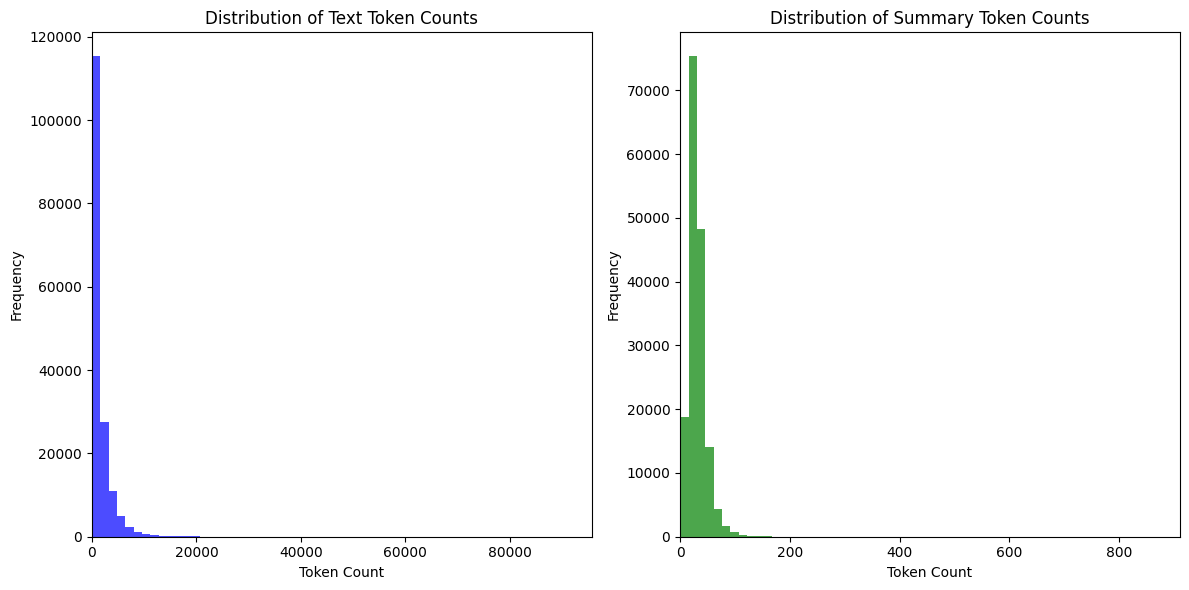

In [ ]:
# Visualizing the distribution of the token counts for both the texts and summaries

# Extracting token counts
text_token_counts = aggregated_data_filtered['text_token_count']
summary_token_counts = aggregated_data_filtered['summary_token_count']

# Determining the upper limit for the x-axis
upper_limit_text = max(text_token_counts) + 5
upper_limit_summary = max(summary_token_counts) + 5

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for text token counts
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(text_token_counts, bins=60, color='blue', alpha=0.7)
plt.title('Distribution of Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.xlim(0, upper_limit_text)

# Histogram for summary token counts
plt.subplot(1, 2, 2)
plt.hist(summary_token_counts, bins=60, color='green', alpha=0.7)
plt.title('Distribution of Summary Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.xlim(0, upper_limit_summary)

# Show the plots
plt.tight_layout()
plt.show()

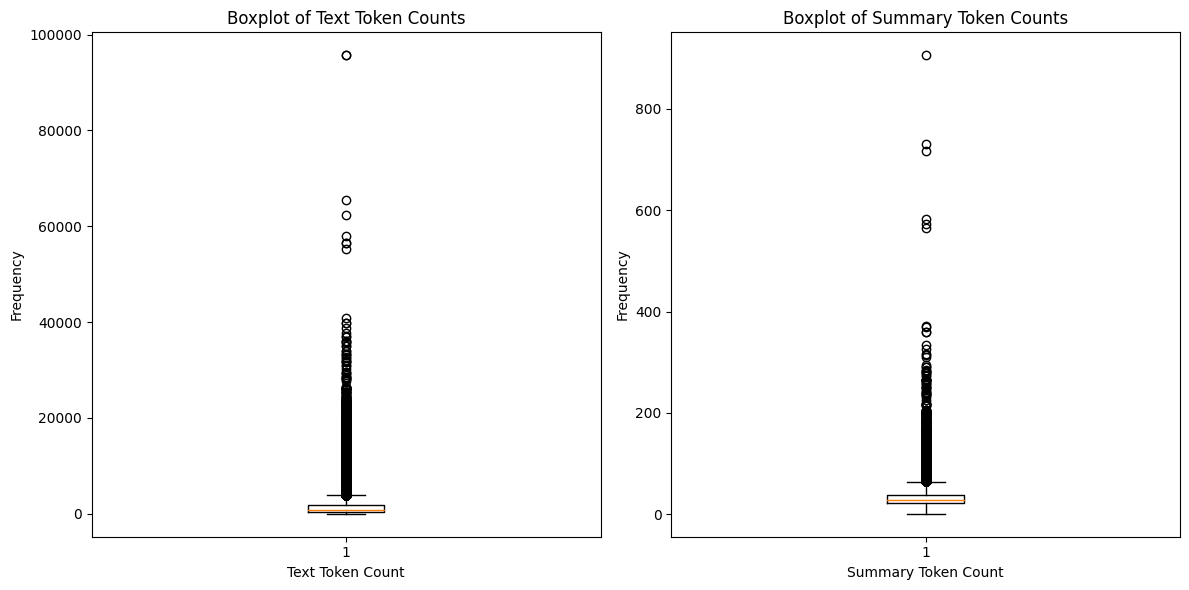

In [ ]:
# Plotting boxplots
plt.figure(figsize=(12, 6))

# Boxplot for text token counts
plt.subplot(1, 2, 1)
plt.boxplot(text_token_counts)
plt.title('Boxplot of Text Token Counts')
plt.xlabel('Text Token Count')
plt.ylabel('Frequency')

# Boxplot for summary token counts
plt.subplot(1, 2, 2)
plt.boxplot(summary_token_counts)
plt.title('Boxplot of Summary Token Counts')
plt.xlabel('Summary Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Saving Amharic-1

# Splitting the dataset
# 80% training, 10% validation, 10% testing
train, temp = train_test_split(aggregated_data_filtered, test_size=0.20, random_state=16)
valid, test = train_test_split(temp, test_size=0.50, random_state=16)

# Save them to different CSVs
train.to_csv(folder_path + 'amharic_1_train.csv', index=False)
valid.to_csv(folder_path + 'amharic_1_valid.csv', index=False)
test.to_csv(folder_path + 'amharic_1_test.csv', index=False)

# Also saving everything to one file to make it available together
aggregated_data_filtered.to_csv(folder_path + 'amharic_1_all.csv', index=False)

## Preparing Amharic-2

Following the initial cleaning steps, the first version of the benchmark dataset (i.e., Amharic-1) was created. A second version of the dataset (i.e., Amharic-2) is then created through the following code by applying further filters based on the lengths of the entries, a decision informed by the initial fine-tuning outcomes using Amharic-1. To address the substantial standard deviation in entry lengths, reasonable upper and lower bounds were established for both the texts and their summaries.

In [ ]:
# Preparing Amharic-2

# Setting thresholds for further refinement
min_text_word_count = 50
max_text_word_count = 1500
min_summary_word_count = 7 # A summary with less than 7 words does not capture much

# Applying the filters based on the thresholds
# The main goal behind this is to reduce the standard deviation in the token counts of the different entries
aggregated_data_filtered_further_cleaned = aggregated_data_filtered[
    (aggregated_data_filtered['text_word_count'] >= min_text_word_count) &
    (aggregated_data_filtered['text_word_count'] <= max_text_word_count) &
    (aggregated_data_filtered['summary_word_count'] >= min_summary_word_count) &
    (aggregated_data_filtered['summary_word_count'] <= aggregated_data_filtered['text_word_count'])
]

# Displaying the first few rows of the filtered DataFrame
print(aggregated_data_filtered_further_cleaned.head())

                                                text  \
0  ባለአምስት ኮከብ ሆቴል ስፔሻላይዝድ ሆስፒታልና የተለያዩ ግዙፍ አገልግሎት...   
1  የግል ባንኮች የተቀማጭ ገንዘብ በአንድ አመት ውስጥ በ276 በመቶ በመጨመ...   
2  በተጠርጣሪዎቹ ላይ የ14 ቀናት ምርመራ ጊዜ ተፈቅዷል ጠቅላይ ሚኒስትር አ...   
3  ከ2006 አም ጀምሮ የፌዴራል ከፍተኛ ፍርድ ቤት በዳኝነት ሲያገለግሉ የቆ...   
6   100ሺ መለስተኛ ሙያ ያላቸው ዜጎችም የስራ እድሉ ተጠቃሚ ይሆናሉ አዲስ...   

                                             summary  is_non_amharic_text  \
0  የአገልግሎት መስጫ ተቋማት ለመገንባት መሬት የጠየቁ በልዩ ሊዝ ተስተናገዱ...                False   
1                 የግል ባንኮች ተቀማጭ ገንዘብ 124 ቢሊዮን ብር ደረሰ                False   
2  በቦምብ ፍንዳታው ምክንያት ኃላፊነታቸውን አልተወጡም የተባሉ ተጠርጣሪዎች ...                False   
3          ለሕገ መንግሥቱ ታማኝ አይደሉም የተባሉት ዳኛ ከኃላፊነታቸው ተነሱ                False   
6      በመስኖ ልማት ለአሥራ ሁለት ሺ የተማሩ ወጣቶች የሥራ ዕድል ሊፈጠር ነው                False   

   is_non_amharic_summary  text_length  summary_length  text_word_count  \
0                   False         2601              58              489   
1                   False         1553            

In [ ]:
# Removing entries where texts have more than 2048 tokens
aggregated_data_filtered_further_cleaned = aggregated_data_filtered_further_cleaned[aggregated_data_filtered_further_cleaned['text_token_count'] <= 2048]

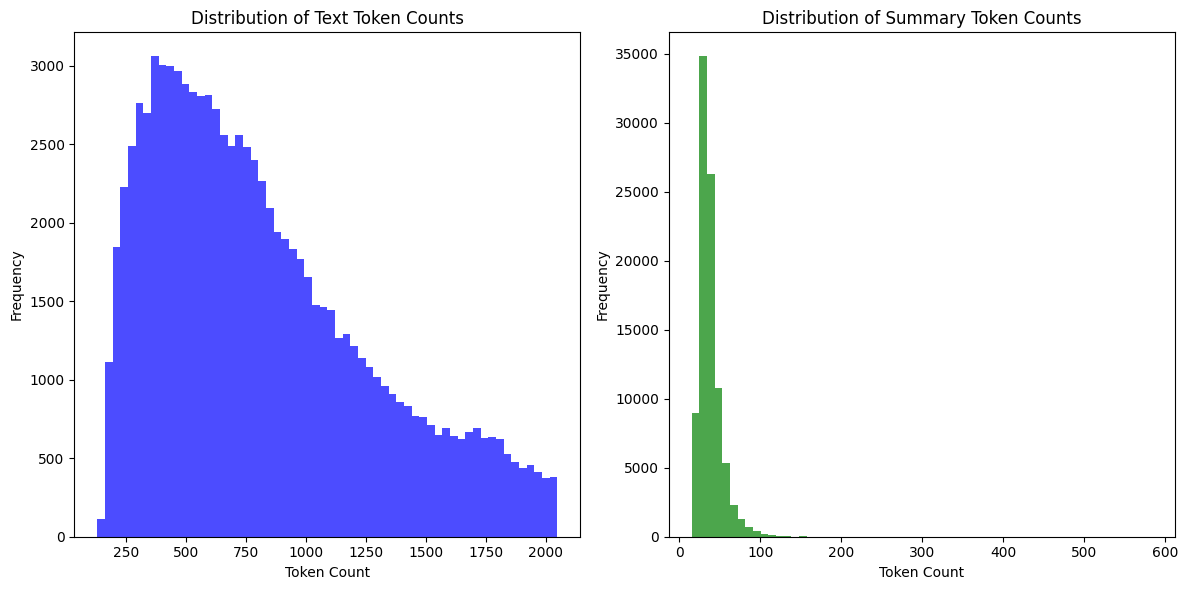

In [ ]:
# Extracting token counts
text_token_counts = aggregated_data_filtered_further_cleaned['text_token_count']
summary_token_counts = aggregated_data_filtered_further_cleaned['summary_token_count']

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for text token counts
plt.subplot(1, 2, 1)
plt.hist(text_token_counts, bins=60, color='blue', alpha=0.7)
plt.title('Distribution of Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

# Histogram for summary token counts
plt.subplot(1, 2, 2)
plt.hist(summary_token_counts, bins=60, color='green', alpha=0.7)
plt.title('Distribution of Summary Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

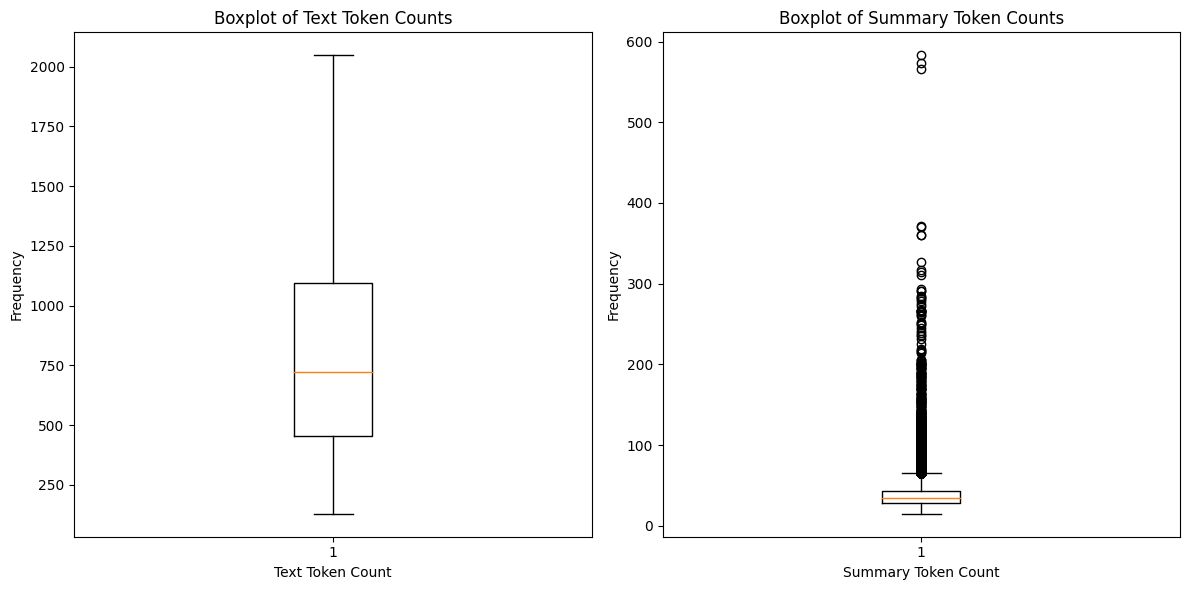

In [ ]:
# Plotting boxplots
plt.figure(figsize=(12, 6))

# Boxplot for text token counts
plt.subplot(1, 2, 1)
plt.boxplot(text_token_counts)
plt.title('Boxplot of Text Token Counts')
plt.xlabel('Text Token Count')
plt.ylabel('Frequency')

# Boxplot for summary token counts
plt.subplot(1, 2, 2)
plt.boxplot(summary_token_counts)
plt.title('Boxplot of Summary Token Counts')
plt.xlabel('Summary Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Looking at the statistics again after further cleaning

# Descriptive statistics
print(aggregated_data_filtered_further_cleaned[['text_length', 'summary_length', 'text_word_count', 'summary_word_count', 'text_token_count', 'summary_token_count']].describe())

# Counting most common words
all_words = ' '.join(aggregated_data_filtered_further_cleaned['text']).split()
word_counts = Counter(all_words)
print("Most common words: ", word_counts.most_common(10))

        text_length  summary_length  text_word_count  summary_word_count  \
count  91406.000000    91406.000000     91406.000000        91406.000000   
mean    1273.221441       56.664497       244.680163           11.008796   
std      713.313864       23.765639       138.850029            4.593633   
min      207.000000       19.000000        50.000000            7.000000   
25%      705.000000       42.000000       134.000000            8.000000   
50%     1120.000000       52.000000       214.000000           10.000000   
75%     1708.000000       64.000000       328.000000           12.000000   
max     4473.000000      885.000000       743.000000          176.000000   

       text_token_count  summary_token_count  
count      91406.000000         91406.000000  
mean         818.361245            37.742719  
std          455.330450            15.782509  
min          129.000000            15.000000  
25%          454.000000            28.000000  
50%          721.000000          

In [ ]:
# Saving Amharic-2

# Randomly splitting the dataset
# 80% training, 10% validation, 10% testing
train, temp = train_test_split(aggregated_data_filtered_further_cleaned, test_size=0.20, random_state=16)
valid, test = train_test_split(temp, test_size=0.50, random_state=16)

# Save them to different CSVs
train.to_csv(folder_path + 'amharic_2_train.csv', index=False)
valid.to_csv(folder_path + 'amharic_2_valid.csv', index=False)
test.to_csv(folder_path + 'amharic_2_test.csv', index=False)

# Also saving everything to one file to make it available together
aggregated_data_filtered_further_cleaned.to_csv(folder_path + 'amharic_2_all.csv', index=False)

## Preparing Amharic-3

The third dataset (i.e., Amharic-3) was then derived by refining the Amharic-2 version through additional cleaning iterations. The following code performs these refinements, and they were guided by established practices in Amharic text preprocessing, utilizing some predefined functions. The justification behind the creation this version as well as the results of using this dataset are outlined in detail in the final report.

In [ ]:
# Load each Amharic-2 dataset from CSV
# All of these files were saved to the same directory all the raw data files are saved and made available
# The path can be updated to wherever these datafiles are stored if that has changed
train_df = pd.read_csv(folder_path + 'amharic_2_train.csv')
valid_df = pd.read_csv(folder_path + 'amharic_2_valid.csv')
test_df = pd.read_csv(folder_path + 'amharic_2_test.csv')

# Concatenate them back into one DataFrame
aggregated_data_filtered_further_cleaned = pd.concat([train_df, valid_df, test_df], ignore_index=True)

In [ ]:
# Creating Normalized Data
# The following three functions are taken from: https://abe2g.github.io/am-preprocess.html
# The full source is cited in detail in the final report
# They are created by an individual who has worked on Amharic text preprocessing

def normalize_char_level_missmatch(input_token):
  '''
    Normalize variations of Amharic characters in a given token to standardize them.

    Args:
        input_token (str): The Amharic token to be normalized.

    Returns:
        str: The normalized Amharic token.
  '''

  rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
  rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
  rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
  rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
  rep5=re.sub('[ሕኅ]','ህ',rep4)
  rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
  rep7=re.sub('[ሠ]','ሰ',rep6)
  rep8=re.sub('[ሡ]','ሱ',rep7)
  rep9=re.sub('[ሢ]','ሲ',rep8)
  rep10=re.sub('[ሣ]','ሳ',rep9)
  rep11=re.sub('[ሤ]','ሴ',rep10)
  rep12=re.sub('[ሥ]','ስ',rep11)
  rep13=re.sub('[ሦ]','ሶ',rep12)
  rep14=re.sub('[ዓኣዐ]','አ',rep13)
  rep15=re.sub('[ዑ]','ኡ',rep14)
  rep16=re.sub('[ዒ]','ኢ',rep15)
  rep17=re.sub('[ዔ]','ኤ',rep16)
  rep18=re.sub('[ዕ]','እ',rep17)
  rep19=re.sub('[ዖ]','ኦ',rep18)
  rep20=re.sub('[ጸ]','ፀ',rep19)
  rep21=re.sub('[ጹ]','ፁ',rep20)
  rep22=re.sub('[ጺ]','ፂ',rep21)
  rep23=re.sub('[ጻ]','ፃ',rep22)
  rep24=re.sub('[ጼ]','ፄ',rep23)
  rep25=re.sub('[ጽ]','ፅ',rep24)
  rep26=re.sub('[ጾ]','ፆ',rep25)

  #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል
  rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
  rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
  rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
  rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
  rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
  rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
  rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
  rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
  rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
  rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
  rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
  rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
  rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
  rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
  rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
  rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
  rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
  rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
  rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
  rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
  rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
  rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ
  return rep48

# :: No longer removed
def remove_punc_and_special_chars(text):
  '''
    Remove punctuation and special characters from a given text.

    Args:
        text (str): The text from which to remove punctuation and special characters.

    Returns:
        str: The text stripped of punctuation and special characters.
  '''

  normalized_text = re.sub('[\!\@\#\$\%\^\«\»\&\*\(\)\…\[\]\{\}\;\“\”\›\’\‘\"\'\:\,\.\‹\/\<\>\?\\\\|\`\´\~\-\=\+\፡\፤\;\፦\፥\፧\፨\፠\፣]', '',text)
  return normalized_text

# Remove all ascii characters
def remove_ascii_and_numbers(text_input):
  '''
    Remove ASCII characters and numbers from the given text.

    Args:
        text_input (str): The text from which to remove ASCII characters and numbers.

    Returns:
        str: The text without any ASCII characters and numbers.
  '''

  return re.sub('[A-Za-z]','',text_input)

In [ ]:
# Normalizing the text and summary columns using the three normalization functions
aggregated_data_filtered_further_cleaned['text'] = aggregated_data_filtered_further_cleaned['text'].apply(
    lambda x: remove_ascii_and_numbers(
        remove_punc_and_special_chars(
            normalize_char_level_missmatch(x))))

aggregated_data_filtered_further_cleaned['summary'] = aggregated_data_filtered_further_cleaned['summary'].apply(
    lambda x: remove_ascii_and_numbers(
        remove_punc_and_special_chars(
            normalize_char_level_missmatch(x))))

# Updating the statistical columns following the normalization steps
# Length of the text and summary
aggregated_data_filtered_further_cleaned['text_length'] = aggregated_data_filtered_further_cleaned['text'].apply(len)
aggregated_data_filtered_further_cleaned['summary_length'] = aggregated_data_filtered_further_cleaned['summary'].apply(len)

# Word count in the text and summary
aggregated_data_filtered_further_cleaned['text_word_count'] = aggregated_data_filtered_further_cleaned['text'].apply(lambda x: len(x.split()))
aggregated_data_filtered_further_cleaned['summary_word_count'] = aggregated_data_filtered_further_cleaned['summary'].apply(lambda x: len(x.split()))

# Token count in the text and summary
aggregated_data_filtered_further_cleaned['text_token_count'] = aggregated_data_filtered_further_cleaned['text'].apply(lambda x: count_tokens(x, tokenizer))
aggregated_data_filtered_further_cleaned['summary_token_count'] = aggregated_data_filtered_further_cleaned['summary'].apply(lambda x: count_tokens(x, tokenizer))

# Showing descriptive statistics of the token counts
aggregated_data_filtered_further_cleaned[['text_token_count', 'summary_token_count']].describe()

,text_token_count,summary_token_count
count,91406.000000,91406.000000
mean,794.655252,36.984684
std,439.623062,15.372627
min,96.000000,9.000000
25%,443.000000,28.000000
50%,703.000000,33.000000
75%,1066.000000,42.000000
max,2048.000000,569.000000


In [ ]:
# Setting the thresholds for Amharic-3
# The reason behind the selection of these values is discussed in the final report.
max_text_token_count = 512
max_summary_word_count = 128

# Applying the filters
bounded_token_length_aggregated_data_filtered_further_cleaned = aggregated_data_filtered_further_cleaned[
    (aggregated_data_filtered_further_cleaned['text_token_count'] <= max_text_token_count) &
    (aggregated_data_filtered_further_cleaned['summary_token_count'] <= max_summary_word_count)
]

# Displaying the first few rows of the filtered DataFrame
print(bounded_token_length_aggregated_data_filtered_further_cleaned.head())

                                                 text  \
17  አዲስ አበባ መጋቢት 8 2012 ኤፍቢሲ ከ13 ሚሊየን ብር በላይ የሚገመቱ...   
18  ከ9 አመታት በፊት ወደ ኢትዮጵያ ከመምጣቱ በፊት ዳዊት ድሪምስ በኤርትራ ...   
19  የኢፌዴሪ ጠቅላይ ሚኒስትር አብይ አህመድ ከአሜሪካው ፕሬዝዳንት ዶናልድ ት...   
23    ደረጃውን የጠበቀ የህክምና አገልግሎት የሚሰጥ ሆስፒታል በመቶ ሚሊየን ...   
25  በሶሪያ አንድ ወር ሊሞላው የተቃረበውን የሰላም ስምምነት በሚጥስ ወገን ላ...   

                                              summary  is_non_amharic_text  \
17              ከ13 ሚሊየን ብር በላይ የሚገመት የኮንትሮባንድ እቃ ተያዘ                False   
18            ፈተናን ወደ መልካም የህይወት ትምህርት የቀየረው ዳዊት ድሪምስ                False   
19  ጠቅላይ ሚኒስትር አብይ አህመድ ከአሜሪካው ፕሬዝዳንት ዶናልድ ትራምፕ ጋር...                False   
23           ኢትዮጵያዊያን ሀኪሞች በሁለት ቢሊየን ብር ሆስፒታል ሊገነቡ ነው                False   
25  በሶሪያን የሰላም ስምምነት በሚጥስ ወገን ላይ ብቸኛ እርምጃ እንደምትወስድ...                False   

    is_non_amharic_summary  text_length  summary_length  text_word_count  \
17                   False          510              37               97   
18                   False          

In [ ]:
bounded_token_length_aggregated_data_filtered_further_cleaned[['text_token_count', 'summary_token_count']].describe()

all_words = ' '.join(bounded_token_length_aggregated_data_filtered_further_cleaned['text']).split()
word_counts = Counter(all_words)
print("Most common words: ", word_counts.most_common(10))

Most common words:  [('ላይ', 35417), ('እና', 25352), ('።', 22192), ('ነው', 18800), ('ወደ', 14620), ('ጋር', 13982), ('ሲሆን', 12207), ('ውስጥ', 12166), ('አቶ', 11625), ('አበባ', 11159)]


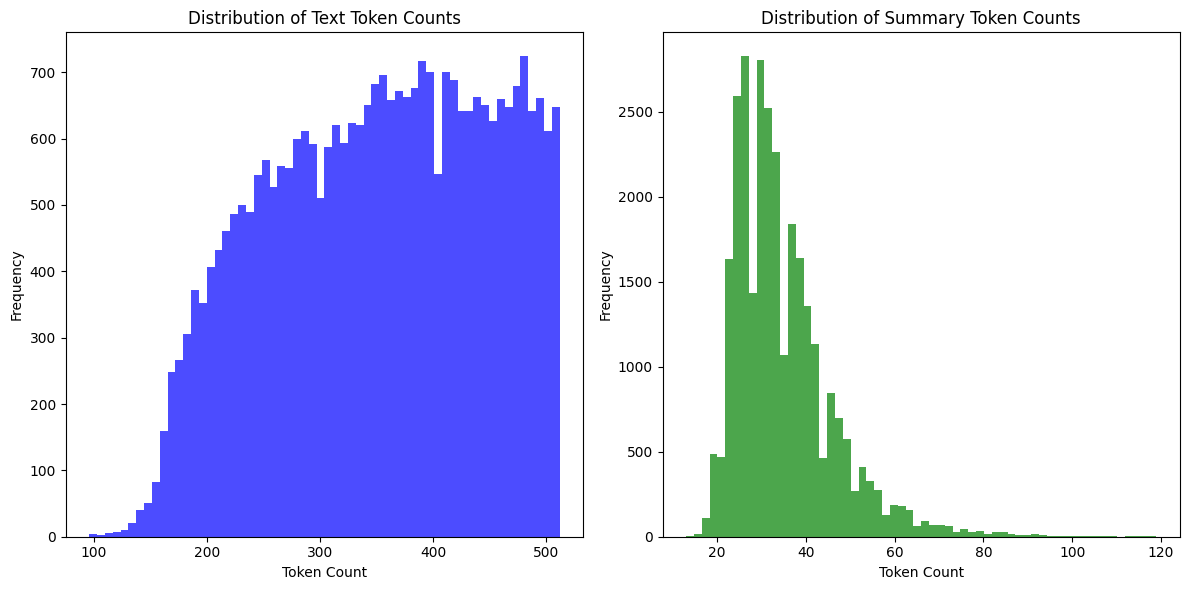

In [ ]:
# Extracting token counts
text_token_counts = bounded_token_length_aggregated_data_filtered_further_cleaned['text_token_count']
summary_token_counts = bounded_token_length_aggregated_data_filtered_further_cleaned['summary_token_count']

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for text token counts
plt.subplot(1, 2, 1)
plt.hist(text_token_counts, bins=60, color='blue', alpha=0.7)
plt.title('Distribution of Text Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

# Histogram for summary token counts
plt.subplot(1, 2, 2)
plt.hist(summary_token_counts, bins=60, color='green', alpha=0.7)
plt.title('Distribution of Summary Token Counts')
plt.xlabel('Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

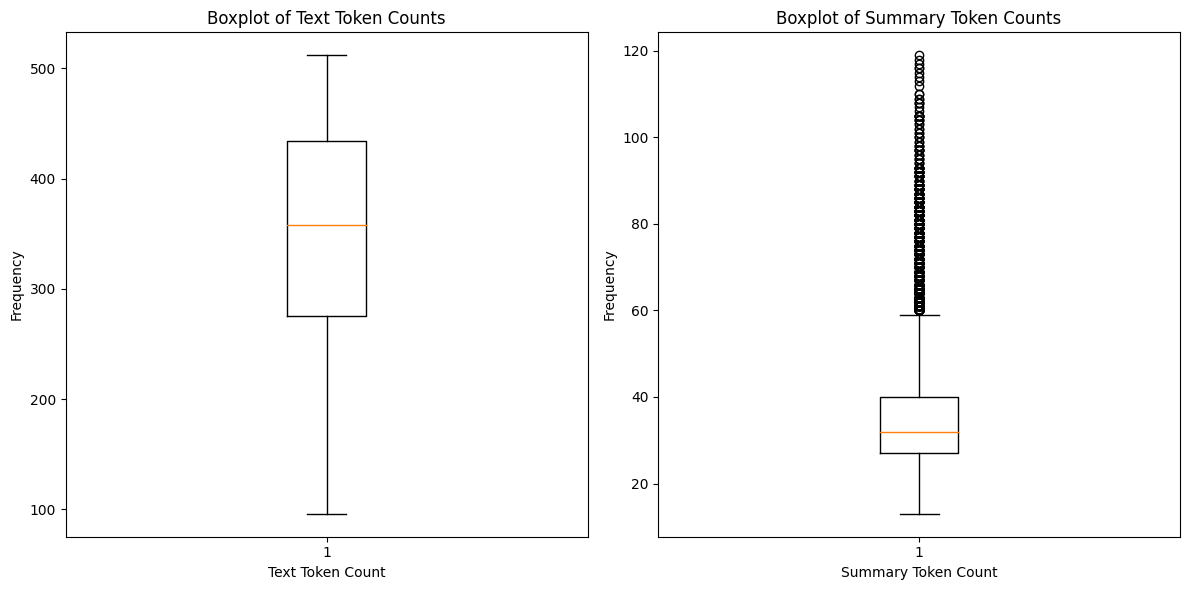

In [ ]:
# Plotting boxplots
plt.figure(figsize=(12, 6))

# Boxplot for text token counts
plt.subplot(1, 2, 1)
plt.boxplot(text_token_counts)
plt.title('Boxplot of Text Token Counts')
plt.xlabel('Text Token Count')
plt.ylabel('Frequency')

# Boxplot for summary token counts
plt.subplot(1, 2, 2)
plt.boxplot(summary_token_counts)
plt.title('Boxplot of Summary Token Counts')
plt.xlabel('Summary Token Count')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Saving Amharic-3

# Splitting the dataset
# 80% training, 10% validation, 10% testing
train, temp = train_test_split(bounded_token_length_aggregated_data_filtered_further_cleaned, test_size=0.20, random_state=16)
valid, test = train_test_split(temp, test_size=0.50, random_state=16)

# Save them to different CSVs
train.to_csv(folder_path + 'amharic_3_train.csv', index=False)
valid.to_csv(folder_path + 'amharic_3_valid.csv', index=False)
test.to_csv(folder_path + 'amharic_3_test.csv', index=False)

# All of it in the same file
bounded_token_length_aggregated_data_filtered_further_cleaned.to_csv(folder_path + 'amharic_3_all.csv', index=False)